In [2]:
# Import necessary libraries
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import os

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Path to the directory containing CSV file in Google Drive
drive_dir = '/content/drive/MyDrive/fifteenyearsdataallinone/'
file_to_read = 'historic_demand_2009_2024_noNaN.csv'

In [5]:
# Function to normalize column names to lowercase
def normalize_column_names(df):
    return df.rename(columns=str.lower)

In [6]:
# Load the data
csv_file_path = os.path.join(drive_dir, file_to_read)
try:
    df = pd.read_csv(csv_file_path)
    df = normalize_column_names(df)
    print(f"CSV file '{file_to_read}' successfully loaded.")
except FileNotFoundError:
    print(f"CSV file '{file_to_read}' not found.")
except pd.errors.ParserError:
    print(f"Error parsing CSV file '{file_to_read}'.")

CSV file 'historic_demand_2009_2024_noNaN.csv' successfully loaded.


In [7]:
# Rename the required columns
df_subset = df[['settlement_date', 'tsd']]
df_subset = df_subset.rename(columns={'settlement_date': 'Datetime', 'tsd': 'Total Consumption'})
# Convert 'Datetime' column to datetime
df_subset['Datetime'] = pd.to_datetime(df_subset['Datetime'])

In [8]:
# Filter and remove rows where the 'Datetime' column falls between '2024-01-01 00:00' and '2024-02-22 23:30'
start_date = pd.Timestamp('2024-01-01 00:00')
end_date = pd.Timestamp('2024-02-22 23:30')
df_subset = df_subset[~((df_subset['Datetime'] >= start_date) & (df_subset['Datetime'] <= end_date))]

In [9]:
# Filter and remove rows where the 'Datetime' column falls between '2009-01-01 00:00' and '2012-12-31 23:30'
start_date = pd.Timestamp('2009-01-01 00:00')
end_date = pd.Timestamp('2012-12-31 23:30')
df_subset = df_subset[~((df_subset['Datetime'] >= start_date) & (df_subset['Datetime'] <= end_date))]

In [10]:
# Display summary
df_subset.info()
print(df_subset.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 192794 entries, 69400 to 262193
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Datetime           192794 non-null  datetime64[ns]
 1   Total Consumption  192794 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.4 MB
                            Datetime  Total Consumption
count                         192794      192794.000000
mean   2018-07-02 12:00:39.969086464       31455.188994
min              2013-01-01 00:00:00       16513.000000
25%              2015-10-02 06:07:30       25970.000000
50%              2018-07-02 12:15:00       30627.500000
75%              2021-04-01 18:22:30       36215.000000
max              2023-12-31 23:30:00       56559.000000
std                              NaN        6990.925522


In [11]:
# Display the first ten rows
print(df_subset.head(10))
# Display the last ten rows
print(df_subset.tail(10))

                 Datetime  Total Consumption
69400 2013-01-01 00:00:00              32789
69401 2013-01-01 00:30:00              33372
69402 2013-01-01 01:00:00              33017
69403 2013-01-01 01:30:00              31917
69404 2013-01-01 02:00:00              30731
69405 2013-01-01 02:30:00              30028
69406 2013-01-01 03:00:00              28766
69407 2013-01-01 03:30:00              27657
69408 2013-01-01 04:00:00              26854
69409 2013-01-01 04:30:00              26400
                  Datetime  Total Consumption
262184 2023-12-31 19:00:00              31700
262185 2023-12-31 19:30:00              30496
262186 2023-12-31 20:00:00              29202
262187 2023-12-31 20:30:00              27980
262188 2023-12-31 21:00:00              26723
262189 2023-12-31 21:30:00              25921
262190 2023-12-31 22:00:00              24977
262191 2023-12-31 22:30:00              24134
262192 2023-12-31 23:00:00              23714
262193 2023-12-31 23:30:00              23732

In [12]:
# Ensure the index is unique by removing duplicate dates
df_subset = df_subset[~df_subset['Datetime'].duplicated(keep='first')]
# Set 'Datetime' column as the index
df_subset.set_index('Datetime', inplace=True)
# Resample the data to a weekly frequency
df_weekly = df_subset.resample('W').mean()

In [13]:
print(df_subset.head(10))

                     Total Consumption
Datetime                              
2013-01-01 00:00:00              32789
2013-01-01 00:30:00              33372
2013-01-01 01:00:00              33017
2013-01-01 01:30:00              31917
2013-01-01 02:00:00              30731
2013-01-01 02:30:00              30028
2013-01-01 03:00:00              28766
2013-01-01 03:30:00              27657
2013-01-01 04:00:00              26854
2013-01-01 04:30:00              26400


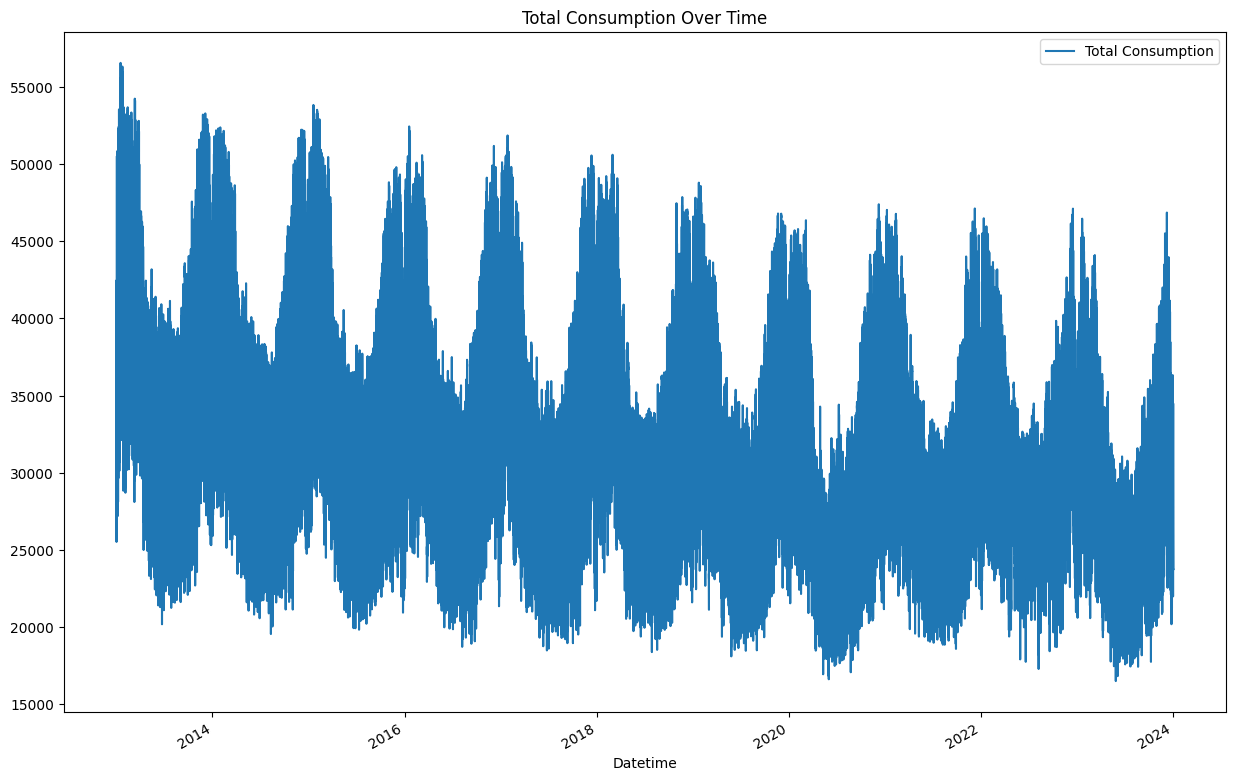

In [14]:
# Plot the DataFrame
df_subset.plot(figsize=(15, 10))
plt.title('Total Consumption Over Time')
plt.show()

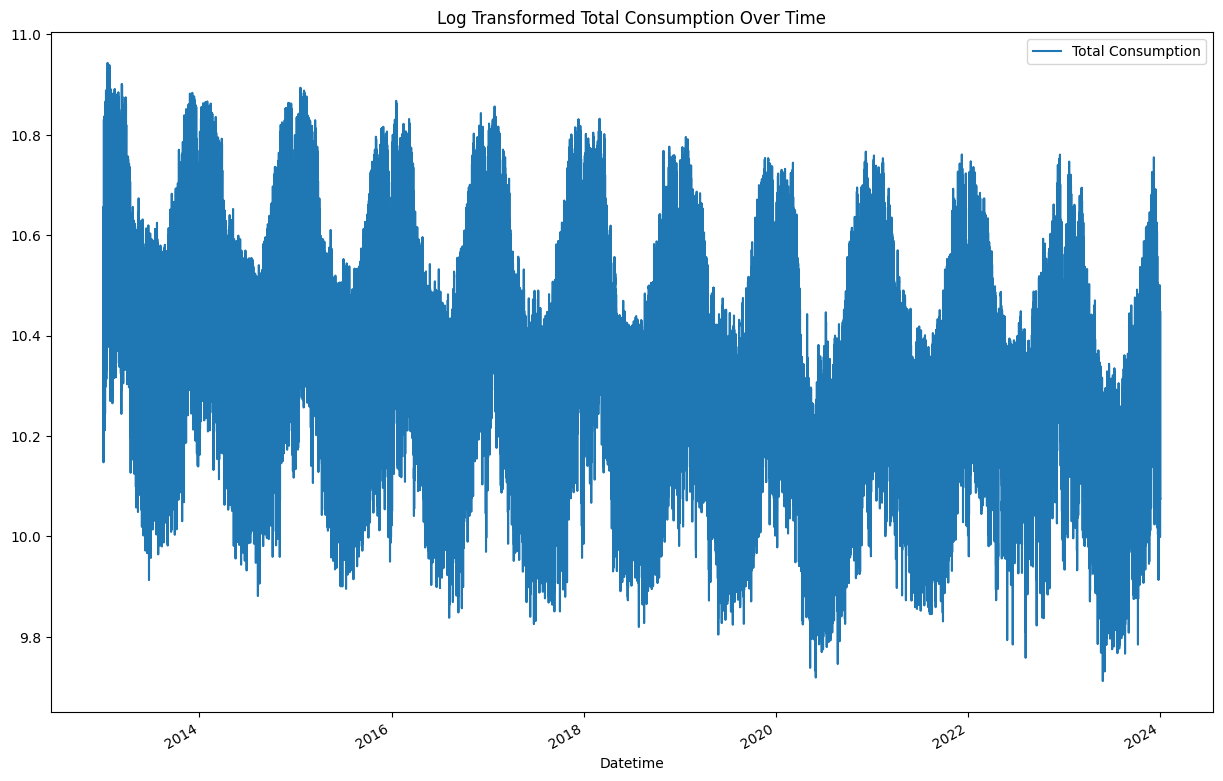

In [15]:
# Transform the series to stabilize its variance
df_subset = np.log(df_subset)
df_subset.plot(figsize=(15, 10))
plt.title('Log Transformed Total Consumption Over Time')
plt.show()

In [16]:
# Calculate the 80/20 split point
split_point = int(len(df_subset) * 0.8)

In [17]:
# Split the DataFrame into train and test sets
df_subset_train = df_subset.iloc[:split_point].copy()
df_subset_test = df_subset.iloc[split_point:].copy()

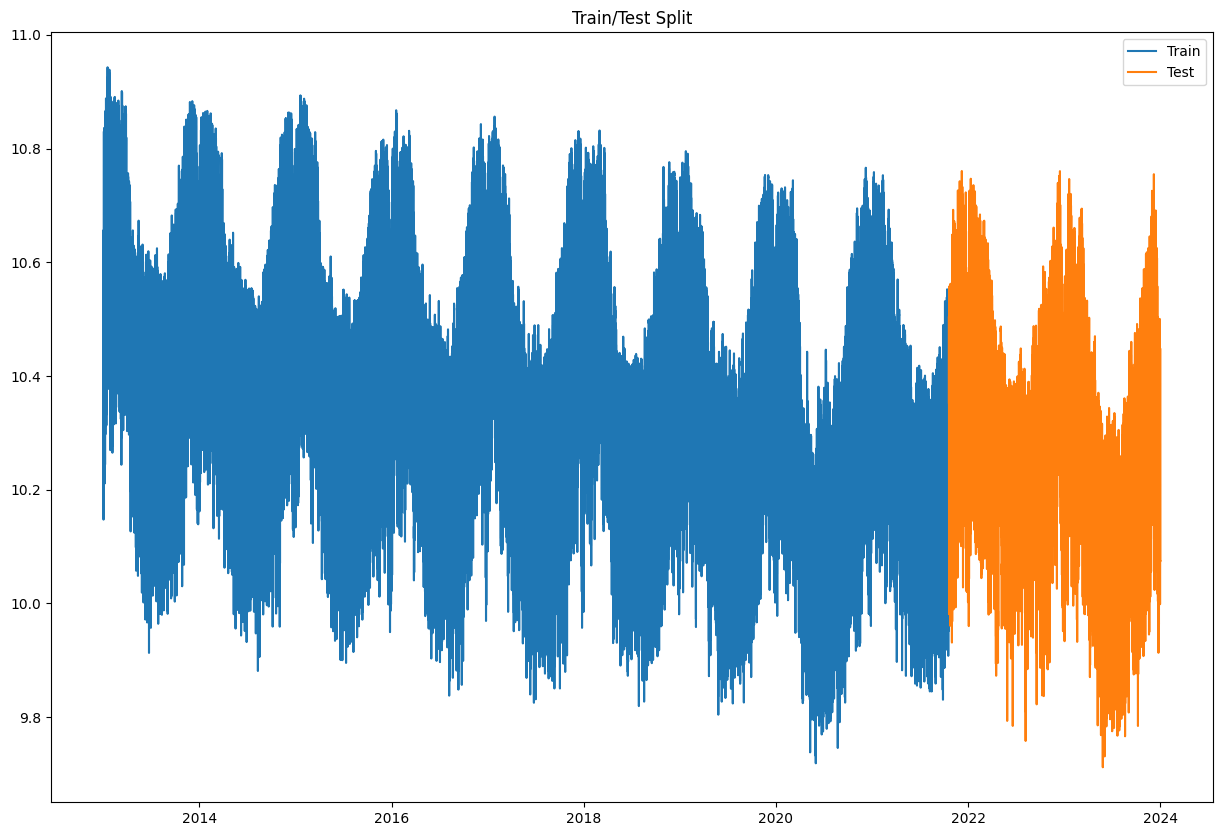

In [18]:
# Plot the training and testing data to visualize the split
plt.figure(figsize=(15, 10))
plt.plot(df_subset_train, label='Train')
plt.plot(df_subset_test, label='Test')
plt.legend()
plt.title('Train/Test Split')
plt.show()

In [19]:
# Check stationarity with Augmented Dickey-Fuller Test on the training set
adf_test = adfuller(df_subset_train)
print(f'p-value: {adf_test[1]}')

p-value: 3.330938406309273e-30


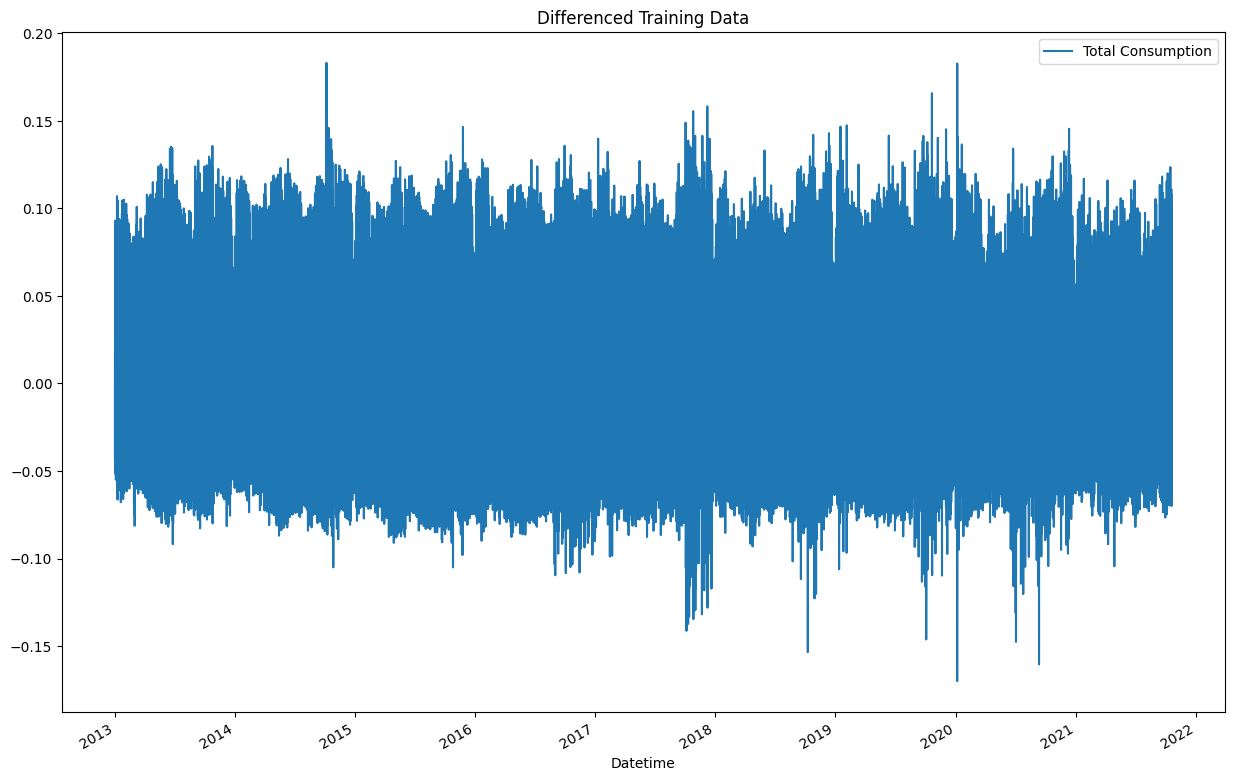

In [20]:
# Differencing the training set to stabilize variance
df_subset_train_diff = df_subset_train.diff().dropna()
df_subset_train_diff.plot(figsize=(15, 10))
plt.title("Differenced Training Data")
plt.show()

In [21]:
# Check stationarity again after differencing
adf_test_diff = adfuller(df_subset_train_diff)
print(f'p-value after differencing: {adf_test_diff[1]}')

p-value after differencing: 0.0


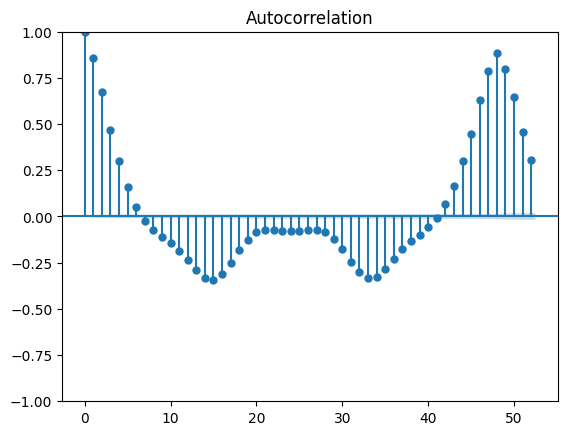

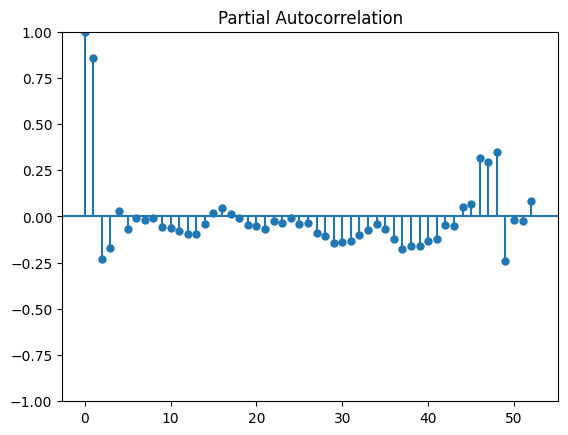

In [22]:
# Autocorrelation and Partial Autocorrelation plots for differenced data
acf_diff = plot_acf(df_subset_train_diff)
pacf_diff = plot_pacf(df_subset_train_diff)

In [23]:
# ARIMA model fitting
model = ARIMA(df_subset_train, order=(2, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      Total Consumption   No. Observations:               154235
Model:                 ARIMA(2, 1, 0)   Log Likelihood              419628.665
Date:                Thu, 06 Jun 2024   AIC                        -839251.331
Time:                        14:09:35   BIC                        -839221.492
Sample:                             0   HQIC                       -839242.448
                             - 154235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0546      0.002    636.932      0.000       1.051       1.058
ar.L2         -0.2307      0.002   -122.963      0.000      -0.234      -0.227
sigma2         0.0003   5.43e-07    466.858      0.0

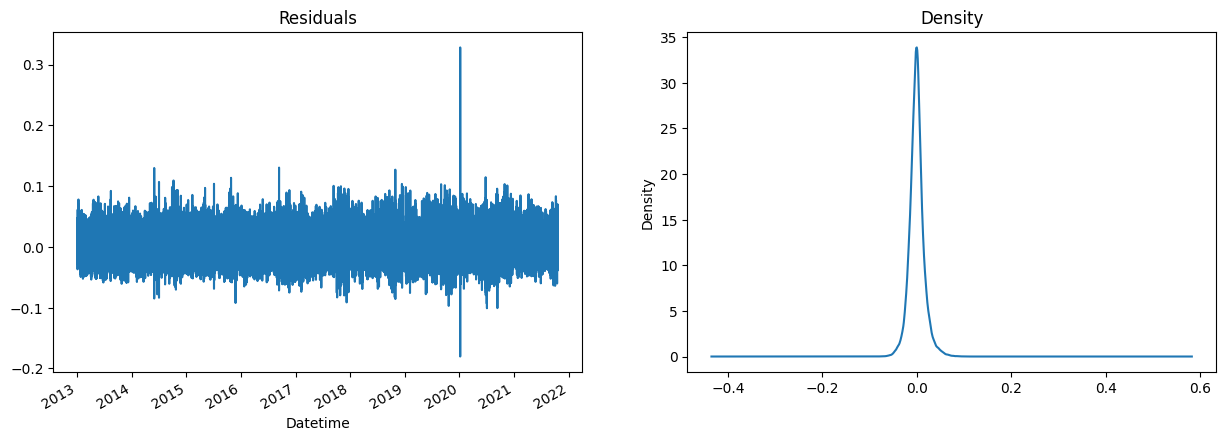

In [24]:
# Residuals analysis
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

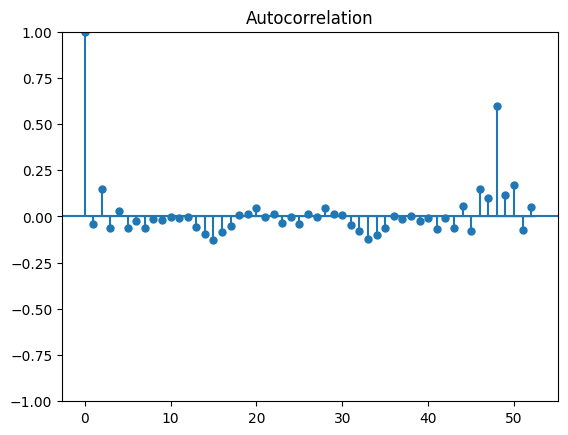

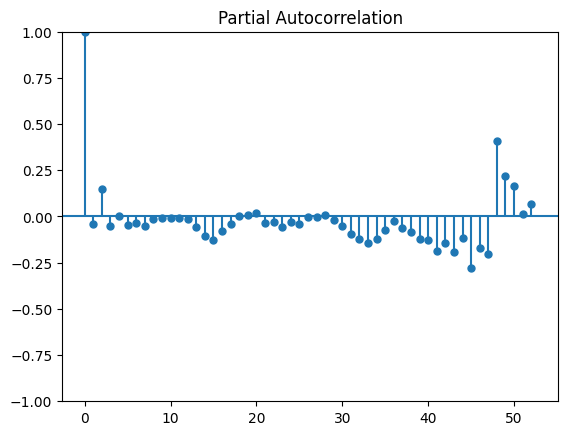

In [25]:
# Autocorrelation and Partial Autocorrelation of residuals
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)


In [26]:
# Forecasting
forecast_test = model_fit.forecast(len(df_subset_test))
df_subset['forecast_manual'] = [None]*len(df_subset_train) + list(forecast_test)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


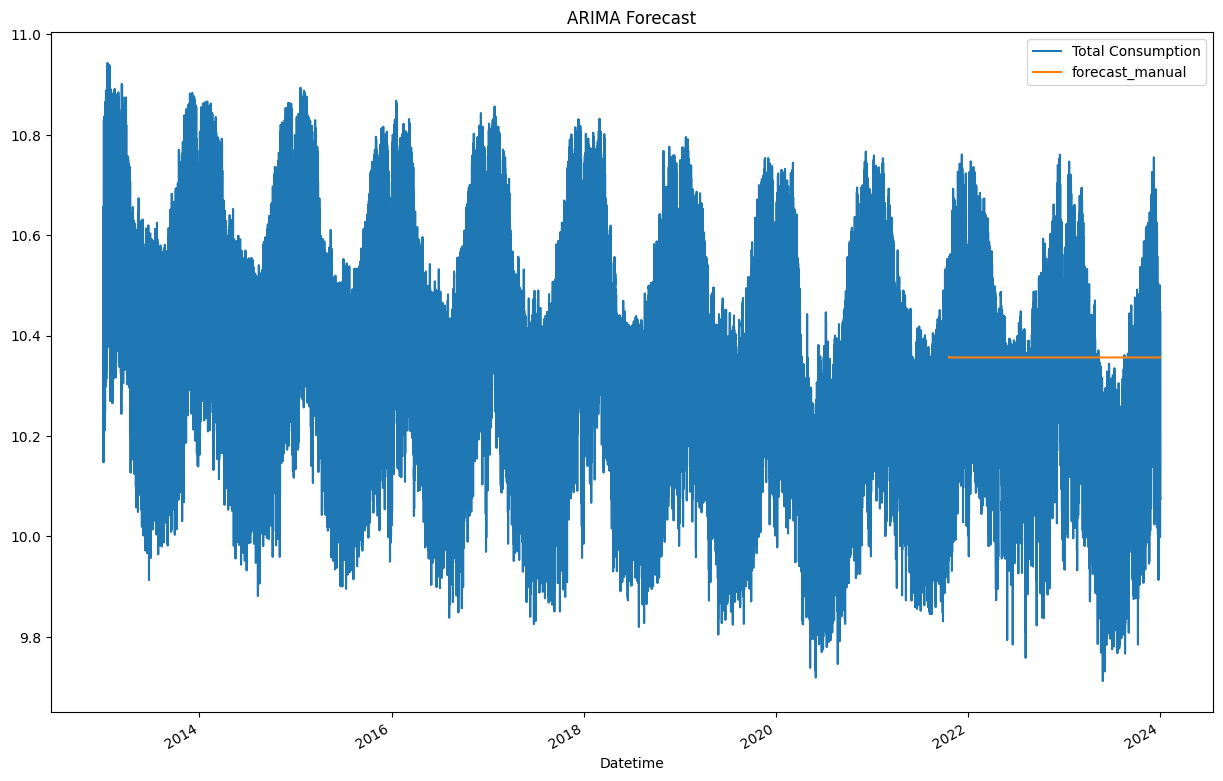

In [27]:
# Plot the original data with the manual forecast
df_subset.plot(figsize=(15, 10))
plt.title("ARIMA Forecast")
plt.show()

In [28]:
# Evaluation metrics for manual forecast
mae_manual = mean_absolute_error(df_subset_test, forecast_test)
mape_manual = mean_absolute_percentage_error(df_subset_test, forecast_test)
rmse_manual = np.sqrt(mean_squared_error(df_subset_test, forecast_test))

print(f'mae - manual: {mae_manual}')
print(f'mape - manual: {mape_manual}')
print(f'rmse - manual: {rmse_manual}')

mae - manual: 0.1797063749225432
mape - manual: 0.017643351257203878
rmse - manual: 0.21665126302667143
